**Final Captcha Solver**

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [3]:

# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string


In [4]:

# Check files in dataset folder
os.listdir("/content/drive/MyDrive/Data/train")

# Total number of images in the dataset
n = len(os.listdir("/content/drive/MyDrive/Data/train"))

# Image shape and characters used in captcha
imgshape = (50, 200, 1)  # 50 height, 200 width, 1 channel
character = "0123456789"  # Only digits for captcha
nchar = len(character)    # Total number of characters (10 for digits 0-9)

# Preprocess images and labels
def preprocess():
    X = np.zeros((n, 50, 200, 1))    # Array for images
    y = np.zeros((4, n, nchar))      # Array for labels (4 digits per captcha, 10 possible classes)

    for i, pic in enumerate(os.listdir("/content/drive/MyDrive/Data/train")):
        img = cv2.imread(os.path.join("/content/drive/MyDrive/Data/train", pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]  # Remove .png extension

        if len(pic_target) == 4:  # Ensure it has exactly 4 digits
            img = img / 255.0  # Scale image to 0-1
            img = np.reshape(img, (50, 200, 1))  # Reshape for model

            target = np.zeros((4, nchar))  # Array to store digit encodings
            for j, k in enumerate(pic_target):
                index = character.find(k)  # Find index of digit in `character`
                target[j, index] = 1       # Set target for the digit

            X[i] = img       # Store processed image
            y[:, i] = target # Store processed label

    return X, y

# Create the model
def createmodel():
    img = layers.Input(shape=imgshape)
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)

    flat = layers.Flatten()(mp3)

    # Create 4 outputs for 4 digits
    outs = []
    for _ in range(4):  # Update for 4 digits
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(nchar, activation='sigmoid')(drop)
        outs.append(res)

    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model


In [11]:
def preprocess():
    X = np.zeros((n, 50, 200, 1))    # Array for images
    y = np.zeros((4, n, nchar))      # Array for labels (4 digits per captcha, 10 possible classes)
    valid_count = 0                  # Count of valid images (50x200)

    for i, pic in enumerate(os.listdir("/content/drive/MyDrive/Data/train")):
        img_path = os.path.join("/content/drive/MyDrive/Data/train", pic)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            # Resize image to (50, 200) if it's not already
            img = cv2.resize(img, (200, 50))
            img = img / 255.0  # Scale image to 0-1
            img = np.reshape(img, (50, 200, 1))  # Reshape for model

            pic_target = pic[:-4]  # Remove .png extension
            if len(pic_target) == 4:  # Ensure it has exactly 4 digits
                target = np.zeros((4, nchar))  # Array to store digit encodings
                for j, k in enumerate(pic_target):
                    index = character.find(k)  # Find index of digit in `character`
                    target[j, index] = 1       # Set target for the digit

                X[valid_count] = img       # Store processed image
                y[:, valid_count] = target # Store processed label
                valid_count += 1
        else:
            print(f"Skipping {img_path} due to loading error")

    # Resize X and y to match the valid images count
    X = X[:valid_count]
    y = y[:, :valid_count]

    return X, y


In [14]:
# Create model
def createmodel():
    img = layers.Input(shape=imgshape)  # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)  # 50x200
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25x100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13x50
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)  # Batch normalization
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 7x25

    flat = layers.Flatten()(mp3)  # Flatten to 1-D

    outs = []
    for _ in range(4):  # For 4 digits in captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)  # Dropout to prevent overfitting
        res = layers.Dense(nchar, activation='sigmoid')(drop)
        outs.append(res)  # Append each output for each digit

    # Compile model and return it
    model = Model(img, outs)  # create model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=["accuracy", "accuracy", "accuracy", "accuracy"]  # Metrics for each output
    )
    return model


In [15]:

# Create model
model = createmodel()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 200, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 50, 200, 16)    │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 25, 100, 16)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 25, 100, 32)    │          4,640 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 13, 50, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 13, 50, 32)     │          9,248 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 13, 50, 32)     │            128 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 7, 25, 32)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 5600)           │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │        358,464 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │        358,464 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 64)             │        358,464 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64)             │        358,464 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_14[0][0]         │
├──────────────────────

 Total params: 1,450,632 (5.53 MB)

 Trainable params: 1,450,568 (5.53 MB)

 Non-trainable params: 64 (256.00 B)

In [12]:

# Preprocess data
X, y = preprocess()

# Split dataset
X_train, y_train = X[:70], y[:, :70]
X_test, y_test = X[70:], y[:, 70:]


In [16]:

# Train model
hist = model.fit(
    X_train, [y_train[0], y_train[1], y_train[2], y_train[3]],
    batch_size=32,
    epochs=60,
    validation_split=0.2
)


Epoch 1/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - dense_11_accuracy: 0.1592 - dense_13_accuracy: 0.2381 - dense_15_accuracy: 0.1265 - dense_9_accuracy: 0.1607 - loss: 10.8451 - val_dense_11_accuracy: 0.1429 - val_dense_13_accuracy: 0.0714 - val_dense_15_accuracy: 0.0714 - val_dense_9_accuracy: 0.1429 - val_loss: 9.0857
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - dense_11_accuracy: 0.1935 - dense_13_accuracy: 0.2485 - dense_15_accuracy: 0.2381 - dense_9_accuracy: 0.2054 - loss: 9.5700 - val_dense_11_accuracy: 0.1429 - val_dense_13_accuracy: 0.0000e+00 - val_dense_15_accuracy: 0.1429 - val_dense_9_accuracy: 0.2143 - val_loss: 9.0787
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - dense_11_accuracy: 0.1354 - dense_13_accuracy: 0.2619 - dense_15_accuracy: 0.1369 - dense_9_accuracy: 0.1696 - loss: 9.0616 - val_dense_11_accuracy: 0.1429 - val_dense_13_accuracy: 0.0000e+00 - val_dense_15_accuracy: 0.1429 - val_dense_9_accuracy: 0.2143 - val_loss: 9.1326
Epoch 4/60
2/2 ━━━━━━━━━━━━━

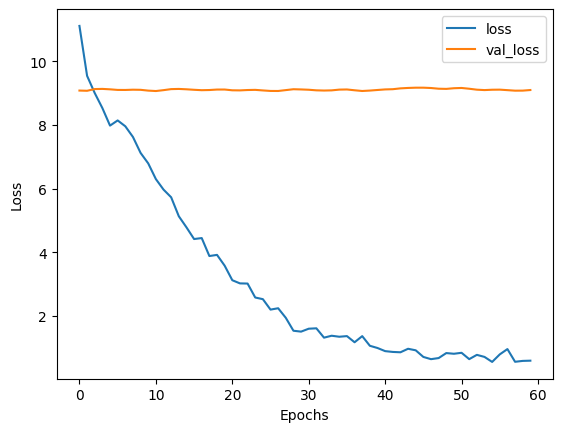

In [18]:

# Plot loss and accuracy
for label in ["loss", "val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [19]:

for i in range(4):
    plt.plot(hist.history[f'val_dense_{2*i+2}_accuracy'], label=f'val_dense_{2*i+2}_accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()


KeyError: 'val_dense_2_accuracy'

In [20]:

# Calculate loss on training and testing sets
train_loss = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3]])
print("Loss on training set =", train_loss[0])

test_loss = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3]])
print("Loss on testing set =", test_loss[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - dense_11_accuracy: 0.8798 - dense_13_accuracy: 0.8687 - dense_15_accuracy: 0.8869 - dense_9_accuracy: 0.8798 - loss: 5.8358
Loss on training set = 6.093872547149658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - dense_11_accuracy: 0.2000 - dense_13_accuracy: 0.0000e+00 - dense_15_accuracy: 0.2000 - dense_9_accuracy: 0.0000e+00 - loss: 9.1466
Loss on testing set = 9.146629333496094


In [23]:
def predict(image_path):
    # Load the image and resize to (50, 200)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (200, 50))  # Resize to match model's expected input
    img = img.reshape(1, 50, 200, 1)  # Add batch dimension and channel

    # Normalize the image
    img = img / 255.0

    # Make predictions
    predictions = model.predict(img)

    # Decode predictions
    result = ''.join([characters[np.argmax(pred)] for pred in predictions])
    return result


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


NameError: name 'characters' is not defined

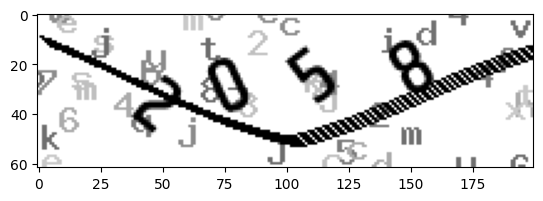

In [24]:

# Test model on sample
img = cv2.imread('/content/drive/MyDrive/Data/train/2058.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
print("Predicted Captcha =", predict('/content/drive/MyDrive/Data/train/2058.png'))

In [25]:
# Define the characters used in the captcha (digits 0-9)
characters = '0123456789'

def predict(image_path):
    # Load the image and resize to (50, 200)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (200, 50))  # Resize to match model's expected input
    img = img.reshape(1, 50, 200, 1)  # Add batch dimension and channel

    # Normalize the image
    img = img / 255.0

    # Make predictions
    predictions = model.predict(img)

    # Decode predictions
    result = ''.join([characters[np.argmax(pred)] for pred in predictions])
    return result


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Captcha = 2559


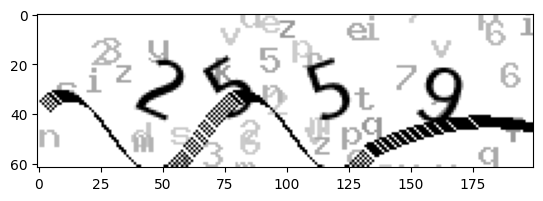

In [31]:
img = cv2.imread('/content/drive/MyDrive/Data/train/2559.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
print("Predicted Captcha =", predict('/content/drive/MyDrive/Data/train/2559.png'))
